# BART

Welcome to analysis of Bay Area Rapid Transit (BART).

__Abstract__: BART and tis introducing the BART Perks pilot program to incentivize riders to reduce their ridership during morning rush hour. We aim to estimate how rider behavior will change during this time based on the flexibility of when riders normally ride and how it may cut down on congestion during rush hour. We estimate the potential cost of the rewards program through the payouts given by the program and see how a program like this long term may be distributed across BART riders.

## Introduction


## BART Perks

https://bartperks.com/

FAQ and details of the program can be found at https://bartperks.com/static/bartperks/files/faq.pdf.

* Looking to recruit 25,000 riders.
* 6 month pilot program, August 2016 - February 2017
* can we scrape data from bartperks site? This has number of miles in the program and some money won
    * 286486 bonus miles this week (monday sept 12 9pm)
    * 387676 bonus miles this week, 507 winners (saturday sept 24 11pm)
    
    
For riders who sign up for the program, they will get one point per mile. However, riding 6:30 - 7:30am or 8:30 - 9:30am are bonus hours. During these times, riders can get 3-6x as many points as normal. Riders can convert 1000 points to 1.00 cash or play BART Perks games. Referring other users can give riders 250 points.

## BART Data

http://www.bart.gov/about/reports/ridership

### hourly ridership 
(date-hour-soo-dest-20XX.csv) for 2011-2016 (http://64.111.127.166/origin-destination/)

2016 for this data are currently available as of August 11th (data through June 30th).

enter and exit data for all combinations of stations. Enter,exit data with zero are excluded, so we have to fill in those records.



__NOTE: Since the data is hourly and the perks is split across hours, there may be some sort of factor needed to determine which half hour people typically fall under__


### Other info
* geo data
    * lat lng from http://api.bart.gov/api/stn.aspx?cmd=stns
    * need to calculate distance from end (use millbrae as common end)
    * compute distances for nearest segments as a proxy of route distance, then add together for total distance
* monthly ridership - is there a seasonal pattern to figure out what it should be fall and spring
* annual ridership 1973-2016
    * probably don't need long term trends

requires a clipper card (59,000 weekday users for bart as of 2010...http://sf.streetsblog.org/2010/10/18/mandatory-switch-from-muni-paper-passes-to-clipper-card-begins-soon/


## Model

Day of week and seasonality trends
* exclude holidays (http://pandas.pydata.org/pandas-docs/stable/timeseries.html#holidays-holiday-calendars)
* uptick in riders are for championship wins

### Cost of the program

Assumptions:
* people convert 1000pts to 1 dollar cash (don't know what the expectation value for the game is, but looks like people typically win 1 or 2 dollars and we can estimate based on the number of winners)
* number of referrals? X referrals per rider
* assumption of the average status of bonus riders (gold on average?)
* distance assumption above based on value per trip


(What is the effective cost to normal bart riders to support this program?)


## BART Visualization App

We have built a web site to visualize the BART data and track the progress of the program. The visualization are build off of Bokeh server app. 

### O-D Hourly Map
http://bokeh.pydata.org/en/latest/docs/gallery/les_mis.html or http://bokeh.pydata.org/en/latest/docs/gallery/chord_chart.html
sort by distance? color by route? northbound vs southbound?



### Folium animation


### Time Series Predictions



In [240]:
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)
import numpy as np
import pandas as pd
from datetime import datetime
from bokeh.plotting import  figure, output_notebook, show
import folium
import xml.etree.ElementTree as ET
from fastkml.kml import KML
import shapely
from shapely.geometry import LineString, Point
import statsmodels.tsa as tsa

Populating the interactive namespace from numpy and matplotlib


In [91]:
station_file_name = "./data/BARTStations.xml"

tree = ET.parse(station_file_name)
root = tree.getroot()

# parse into dictionary - keys ABRV and values (LAT, LNG)
station_latlng = {s[1].text:(float(s[2].text), float(s[3].text)) for s in root[1]}
print(station_latlng.keys())

['SHAY', 'FTVL', 'CIVC', 'COLS', 'PLZA', 'WOAK', 'CONC', 'NCON', 'SFIA', 'WDUB', 'DALY', '24TH', 'SBRN', 'HAYW', 'LAFY', 'DBRK', '12TH', 'PHIL', 'PITT', 'CAST', 'MONT', 'POWL', 'ROCK', 'SANL', '16TH', 'SSAN', 'BALB', 'DELN', 'MCAR', 'DUBL', 'EMBR', 'WCRK', 'MLBR', 'GLEN', 'NBRK', 'ORIN', 'BAYF', 'LAKE', 'ASHB', 'UCTY', '19TH', 'COLM', 'RICH', 'FRMT', 'OAKL']


In [212]:
# read KML file into shapely routes

kml_file = "./data/bart.kml"
f = open(kml_file).read()
k = KML()
k.from_string(f)

features = list(k.features())
f2 = list(features[0].features())

bart_stations = f2[0]
bart_tracks = f2[2]

route_dict = dict()
for route in list(bart_tracks.features()):
    # shapely linestrings from Points
    route_name = route.name
    shapely_linestring = route._geometry.geometry
    route_dict[route_name] = shapely_linestring

stations = dict()
for station in list(bart_stations.features()):
    # get names and positions for bart stations
    short_name = station.name.split("(")[1].split(")")[0]
    stations[short_name] = [station.geometry.y, station.geometry.x]


In [146]:
file_names = ["./data/date-hour-soo-dest-2016.csv","./data/date-hour-soo-dest-2015.csv",
              "./data/date-hour-soo-dest-2014.csv", "./data/date-hour-soo-dest-2013.csv",
              "./data/date-hour-soo-dest-2012.csv", "./data/date-hour-soo-dest-2011.csv"]

bart_dfs = [pd.read_csv(file_name, header = None, 
                      names = ["Day", "Hour", "Enter", "Exit", "Count"]) for file_name in file_names]

bart_df = pd.concat(bart_dfs)

In [147]:
bart_df = bart_df[((bart_df["Hour"] > 6) & (bart_df["Hour"] < 11) & (bart_df["Count"] > 2 ))]

In [230]:
bart_df[["Exit", "Enter"]].unique()

AttributeError: 'DataFrame' object has no attribute 'unique'

In [213]:
"""Section of helper functions applied to the pandas dataframes
"""
def convert_date(s):
    """datetime is unicode string so easier to just assign like this
    """
    # s (unicode string)
    return datetime.strptime(str(s),"%Y-%m-%d %H")

def assign_points(t):
    """ Set the amount of points depending on the hour
    t - datetime string with date and hour
    """
    multiplier = 1
    return multiplier

def get_distance(enter, exit):
    # get the position     
    enter_lat_lng = stations[enter]
    exit_lat_lng = stations[exit]
    return (abs(enter_lat_lng[0]-exit_lat_lng[0]) + abs(enter_lat_lng[1] - exit_lat_lng[1]) )
    

In [238]:
# get distinct combinations and determine the distance then map it to the df for speed
enter_exit_len = dict()
for s in stations:
    for r in stations:
       enter_exit_len[",".join([r,s])] = get_distance(r,s)

In [149]:
bart_df["Day_Hour"] = bart_df.apply(lambda row: row["Day"] + " " + str(row["Hour"]), axis = 1)
bart_df["Time"] = bart_df["Day_Hour"].apply(convert_date)
bart_df.index = bart_df["Time"]
bart_df["Day of Week"] = bart_df["Time"].apply(datetime.weekday)

In [151]:
day_of_week = bart_df.groupby("Day of Week")
hour_index = bart_df.groupby("Hour")
exit_index = bart_df.groupby("Exit")

In [33]:
output_notebook()
hour_plot = figure(x_axis_label = "Hour", y_axis_label = "Count")

hour_plot.line(hour_index["Count"].sum().axes, hour_index["Count"].sum().axes)

Loading BokehJS ...

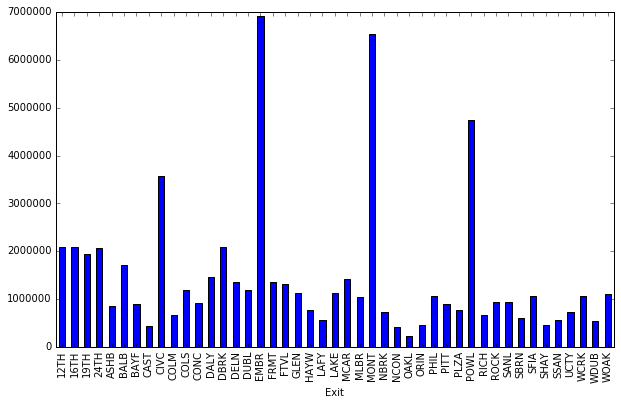

In [9]:
exit_index["Count"].sum().plot(kind="bar")

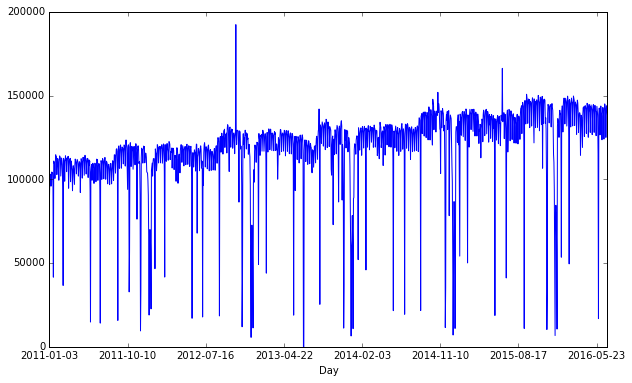

In [153]:
bart_df[(bart_df["Day of Week"] < 5)].groupby("Day")["Count"].sum().plot(kind="line")

In [155]:
gb = bart_df[(bart_df["Day of Week"] < 5)].groupby("Day")["Count"].sum()

Day
2011-01-03     88220
2011-01-04    101604
2011-01-05    103146
2011-01-06    102751
2011-01-07     95957
Name: Count, dtype: int64

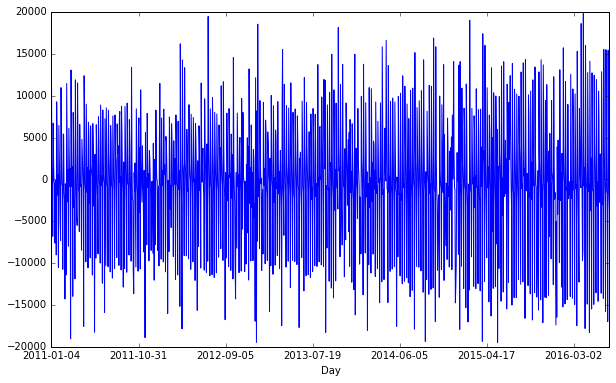

In [166]:
gb_diff = gb.diff()
gb_diff = gb_diff[(gb_diff < 20000) & (gb_diff > -20000)]
gb_diff.plot()

In [163]:
gb_diff.mean(), gb_diff.std()

(35.446078431372548, 23132.514343465333)

In [124]:
daily_8am = bart_df[(bart_df.index.hour == 8) & (bart_df["Day of Week"] < 5)].groupby("Day")["Count"].sum()

In [125]:
daily_8am.index = pd.to_datetime(daily_8am.index)
daily_8am = daily_8am.astype("float64")
daily_8am = daily_8am[daily_8am >40000]
daily_8am_diff = daily_8am.diff()

In [126]:
sma = tsa.arima_model.ARIMA(daily_8am_diff, (5,0,0)).fit()

LinAlgError: Array must not contain infs or NaNs

In [115]:
sma.params, sma.aic

(const          51153.934686
 ar.L1.Count        0.009050
 ar.L2.Count       -0.116552
 ar.L3.Count       -0.102724
 ar.L4.Count        0.098245
 ar.L5.Count        0.469528
 dtype: float64, 2353.764769794499)

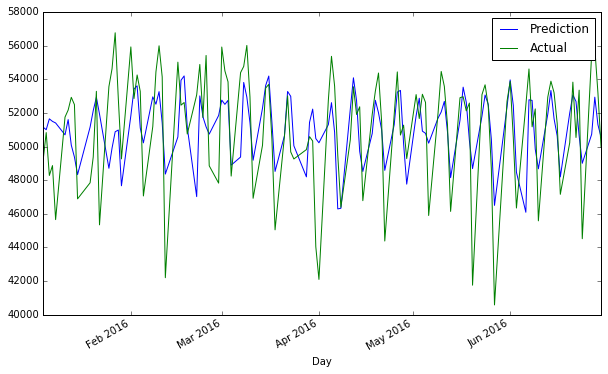

In [122]:
pred = sma.predict()
pred.plot(label = "Prediction")
daily_8am.plot(label = "Actual")
plt.legend()

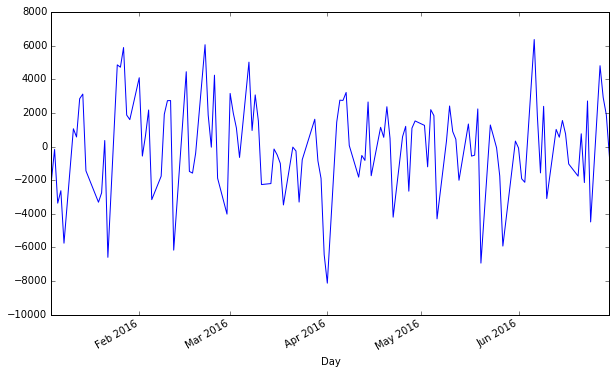

In [116]:
sma.resid.plot()

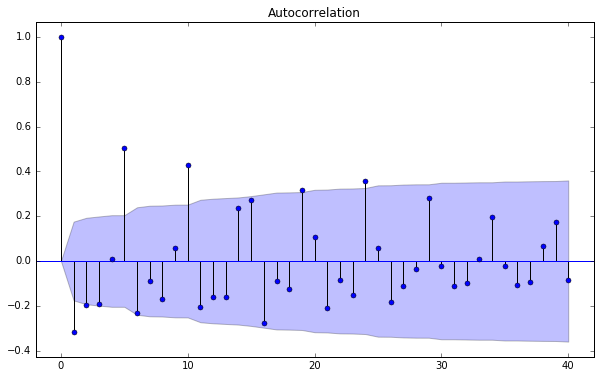

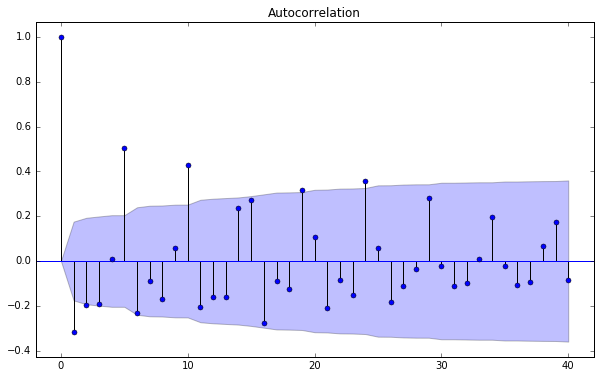

In [130]:
sm.graphics.tsa.plot_acf(daily_8am_diff, lags = 40)

In [129]:
daily_8am_diff = daily_8am_diff.dropna()